**Описание проекта**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.

Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.
Критерии, которые важны заказчику:

качество предсказания;

время обучения модели;

время предсказания модели.


Описание данных

  * DateCrawled — дата скачивания анкеты из базы
  * VehicleType — тип автомобильного кузова
  * RegistrationYear — год регистрации автомобиля
  * Gearbox — тип коробки передач
  * Power — мощность (л. с.)
  * Model — модель автомобиля
  * Kilometer — пробег (км)
  * RegistrationMonth — месяц регистрации автомобиля
  * FuelType — тип топлива
  * Brand — марка автомобиля
  * Repaired — была машина в ремонте или нет
  * DateCreated — дата создания анкеты
  * NumberOfPictures — количество фотографий автомобиля
  * PostalCode — почтовый индекс владельца анкеты (пользователя)
  * LastSeen — дата последней активности пользователя

Целевой признак: Price — цена (евро)

## Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
import time

In [ ]:
df = pd.read_csv('/datasets/autos.csv', decimal = ',')

In [ ]:
df.head(2)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [ ]:
df = df.drop(['DateCrawled'], axis=1)
df = df.drop(['LastSeen'], axis=1)
df = df.drop(['DateCreated'], axis=1)

мне кажется, что эти данные не особо информативны, поэтому удалила их

In [ ]:
table0 = df[df['NotRepaired'] == 'yes']['RegistrationYear'].dropna()
table1 = df[df['NotRepaired'] == 'no']['RegistrationYear'].dropna()
table0 = table0[table0 > 1950]
table0 = table0[table0 < 2020]
table1 = table1[table1 > 1950]
table1 = table1[table1 < 2020]

Делаю предположение, что машины, с датой регистрации до определнного года в своем большинстве были ремонтированы. Дату выбрала по графикам - 2010 и заменила все отсутствующие значения в столбце NotRepaired на yes.

<AxesSubplot:>

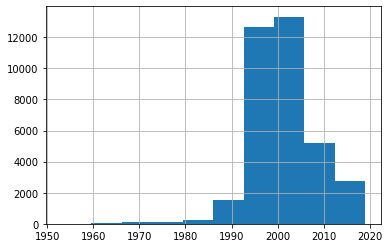

In [ ]:
table0.hist()

<AxesSubplot:>

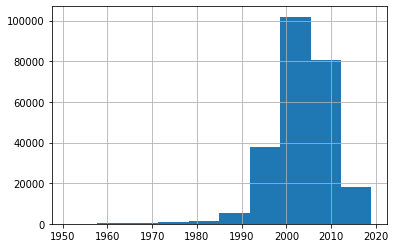

In [ ]:
table1.hist()

In [ ]:
df_NotRepaired = df[df['NotRepaired'].isna()]
df_NotRepaired_before_2010 = df_NotRepaired[df_NotRepaired.RegistrationYear < 2010]
df.iloc[df_NotRepaired_before_2010.index, df.columns.get_loc('NotRepaired')] = 'yes'

In [ ]:
df.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          13455
NumberOfPictures         0
PostalCode               0
dtype: int64

Так как незаполненных значений в столбцах достаточно много, я просто помечу их в отдельном столбце (mistake), что бы при обучении сравнить разницу между грязными и чистыми данными. Так же в этом столбце помечу такие аномалии как мощность = 0.

In [ ]:
df['VehicleType'] = df['VehicleType'].fillna('unknown')
df['Gearbox'] = df['Gearbox'].fillna('unknown')
df['Model'] = df['Model'].fillna('unknown')
df['FuelType'] = df['FuelType'].fillna('unknown')
df['NotRepaired'] = df['NotRepaired'].fillna('unknown')

In [ ]:
df['mistake'] = 0
df.iloc[df['VehicleType'] == 'unknown', df.columns.get_loc('mistake')] = 1
df.iloc[df['Gearbox'] == 'unknown', df.columns.get_loc('mistake')] = 1
df.iloc[df['Model'] == 'unknown', df.columns.get_loc('mistake')] = 1
df.iloc[df['FuelType'] == 'unknown', df.columns.get_loc('mistake')] = 1
df.iloc[df['NotRepaired'] == 'unknown', df.columns.get_loc('mistake')] = 1

df.iloc[df['Power'] == 0, df.columns.get_loc('mistake')] = 1
df.iloc[df['RegistrationMonth'] == 0, df.columns.get_loc('mistake')] = 1
df.iloc[df['RegistrationYear'] > 2020, df.columns.get_loc('mistake')] = 1
df.iloc[df['RegistrationYear'] < 1950, df.columns.get_loc('mistake')] = 1
df['mistake'].value_counts()

0    255499
1     98870
Name: mistake, dtype: int64

In [ ]:
df['mistake'].value_counts()[1] / df.shape[0]

0.2790029601912131

всего аномалий нашлось 28%, многовато для случайной замены или удаления

<AxesSubplot:>

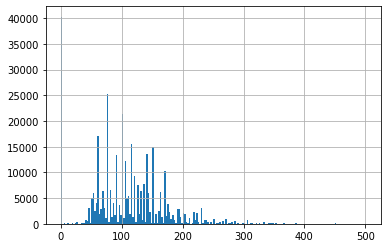

In [ ]:
df.Power.hist(bins = 200, range=(0, 500))

In [ ]:
df.iloc[df['Power'] < 20, df.columns.get_loc('mistake')] = 1

df.iloc[df['Power'] > 500, df.columns.get_loc('mistake')] = 1

In [ ]:
df = df[df.Price > 10]

## Подготовка выборки

In [ ]:
df_ohe = pd.get_dummies(df)

oe = OrdinalEncoder()
oe.fit(df[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']])
encoded_columns = oe.transform(df[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']])
df_oe = df.copy()
df_oe[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']] = encoded_columns
# oe.transform(oe_first['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'])

Заменила категориальные значения на номера их индексов из списка уникальных значений. Пробовала dummy кодирование и получила 322 столбца, на мой взгляд показалось многовато.

In [ ]:
target_ohe = df_ohe['Price']
features_ohe = df_ohe.drop(['Price'] , axis=1)

features_80_ohe, features_test_ohe, target_80_ohe, target_test_ohe = train_test_split(
    features_ohe, target_ohe, test_size=0.2, random_state=12345)

features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(
    features_80_ohe, target_80_ohe, test_size=0.25, random_state=12345)


target_b_ohe = df_ohe[df_ohe.mistake == 0]['Price']
features_b_ohe = features_ohe[features_ohe.mistake == 0]

features_80_b_ohe, features_test_b_ohe, target_80_b_ohe, target_test_b_ohe = train_test_split(
    features_b_ohe, target_b_ohe, test_size=0.2, random_state=12345)

features_train_b_ohe, features_valid_b_ohe, target_train_b_ohe, target_valid_b_ohe = train_test_split(
    features_80_b_ohe, target_80_b_ohe, test_size=0.25, random_state=12345)


target_oe = df_oe['Price']
features_oe = df_oe.drop(['Price'] , axis=1)

features_80_oe, features_test_oe, target_80_oe, target_test_oe = train_test_split(
    features_oe, target_oe, test_size=0.2, random_state=12345)

features_train_oe, features_valid_oe, target_train_oe, target_valid_oe = train_test_split(
    features_80_oe, target_80_oe, test_size=0.25, random_state=12345)


target_b_oe = df_oe[df_ohe.mistake == 0]['Price']
features_b_oe = features_oe[features_oe.mistake == 0]

features_80_b_oe, features_test_b_oe, target_80_b_oe, target_test_b_oe = train_test_split(
    features_b_oe, target_b_ohe, test_size=0.2, random_state=12345)

features_train_b_oe, features_valid_b_oe, target_train_b_oe, target_valid_b_oe = train_test_split(
    features_80_b_oe, target_80_b_oe, test_size=0.25, random_state=12345)

Разбила на выборки для обучения модели. Первая по всем данным, вторая по данным без флага в столбце mistake

In [ ]:
numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode', 'mistake']

scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])
features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric])

scaler_b_ohe = StandardScaler()
scaler_b_ohe.fit(features_train_b_ohe[numeric])
features_train_b_ohe[numeric] = scaler.transform(features_train_b_ohe[numeric])
features_test_b_ohe[numeric] = scaler.transform(features_test_b_ohe[numeric])
features_valid_b_ohe[numeric] = scaler.transform(features_valid_b_ohe[numeric])

scaler = StandardScaler()
scaler.fit(features_train_oe[numeric])
features_train_oe[numeric] = scaler.transform(features_train_oe[numeric])
features_test_oe[numeric] = scaler.transform(features_test_oe[numeric])
features_valid_oe[numeric] = scaler.transform(features_valid_oe[numeric])

scaler_b_oe = StandardScaler()
scaler_b_oe.fit(features_train_b_oe[numeric])
features_train_b_oe[numeric] = scaler.transform(features_train_b_oe[numeric])
features_test_b_oe[numeric] = scaler.transform(features_test_b_oe[numeric])
features_valid_b_oe[numeric] = scaler.transform(features_valid_b_oe[numeric])

/tmp/ipykernel_86/3624378564.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_86/3624378564.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

отнормировала данные, что бы модель не выделяла некоторые признаки, как более важные.

## Обучение моделей

Модель LightGBM

In [ ]:
max_leaves = 0
max_rmse = 0
for leaves in range(11, 50, 9):    # 11
    Forest_model_ohe = lgb.LGBMRegressor(boosting_type = 'gbdt', num_leaves = leaves, n_estimators = 1, class_weight = None)
    Forest_model_ohe.fit(features_train_ohe, target_train_ohe)
    if max_rmse < (mean_squared_error(target_test_ohe, Forest_model_ohe.predict(features_test_ohe)))**0.5:
        max_rmse = (mean_squared_error(target_test_ohe, Forest_model_ohe.predict(features_test_ohe)))**0.5
        max_leaves = leaves
    
print('max_leaves =', max_leaves) 
print('RMSE =', max_rmse)

max_leaves = 11
RMSE = 4249.048594910759


In [ ]:
model_gbm_ohe = lgb.LGBMRegressor(boosting_type = 'gbdt', num_leaves = 11, n_estimators = 1, class_weight = None)
model_gbm_ohe.fit(features_train_ohe, target_train_ohe)
print('RMSE на полной выборке', (mean_squared_error(target_test_ohe, model_gbm_ohe.predict(features_test_ohe)))**0.5)

model_gbm_b_ohe = lgb.LGBMRegressor(boosting_type = 'gbdt', num_leaves = 11, n_estimators = 1, class_weight = None)
model_gbm_b_ohe.fit(features_train_b_ohe, target_train_b_ohe)
print('RMSE на выборке без ошибок', (mean_squared_error(target_test_b_ohe, model_gbm_b_ohe.predict(features_test_b_ohe)))**0.5)

RMSE на полной выборке 4249.048594910759
RMSE на выборке без ошибок 4346.225559506319


RandomForestRegressor

In [ ]:
max_depth_oe = 0
max_rmse_oe = 0
for depth in range(11, 50, 9):    # 11
    Forest_model_oe = RandomForestRegressor(n_estimators=20, max_depth=depth, random_state=999)
    Forest_model_oe.fit(features_train_oe, target_train_oe)
    if max_rmse_oe < (mean_squared_error(target_test_oe, Forest_model_oe.predict(features_test_oe)))**0.5:
        max_rmse_oe = (mean_squared_error(target_test_oe, Forest_model_oe.predict(features_test_oe)))**0.5
        max_depth_oe = depth
    
print('max_depth =', max_depth_oe) 
print('RMSE =', max_rmse_oe)

max_depth = 11
RMSE = 1887.514817626876


In [ ]:
max_trees_oe = 0
max_rmse_oe = 0
for trees in range(11, 50, 9):    # 11
    Forest_model_oe = RandomForestRegressor(n_estimators=trees, max_depth=11, random_state=999)
    Forest_model_oe.fit(features_train_oe, target_train_oe)
    if max_rmse_oe < (mean_squared_error(target_test_oe, Forest_model_oe.predict(features_test_oe)))**0.5:
        max_rmse_oe = (mean_squared_error(target_test_oe, Forest_model_oe.predict(features_test_oe)))**0.5
        max_trees_oe = trees
print('n_estimators =', max_trees_oe) 
print('RMSE', max_rmse_oe)  

n_estimators = 11
RMSE 1895.9515066608844


In [ ]:
model_Forest_oe = RandomForestRegressor(n_estimators=11, max_depth=11, random_state=999)
model_Forest_oe.fit(features_train_oe, target_train_oe)
print('RMSE на выборке без ошибок', (mean_squared_error(target_test_oe, model_Forest_oe.predict(features_test_oe)))**0.5)

model_Forest_b_oe = RandomForestRegressor(n_estimators=11, max_depth=11, random_state=999)
model_Forest_b_oe.fit(features_train_b_oe, target_train_b_oe)
print('RMSE на выборке без ошибок', (mean_squared_error(target_test_b_oe, model_Forest_b_oe.predict(features_test_b_oe)))**0.5)

RMSE на выборке без ошибок 1895.9076625995763
RMSE на выборке без ошибок 1784.1966947737503


## Анализ моделей

In [ ]:
print('Модель LGBMRegressor на полной выборке')
start_time = time.time()
model_gbm_ohe = lgb.LGBMRegressor(boosting_type = 'gbdt', num_leaves = 11, n_estimators = 1, class_weight = None)
model_gbm_ohe.fit(features_train_ohe, target_train_ohe)
print("модель обучается %s секунд" % round((time.time() - start_time),2))

start_time = time.time()
prediction_gmb = model_gbm_ohe.predict(features_valid_ohe)
print("модель предсказывает %s секунд" % round((time.time() - start_time), 2))

print('RMSE', (mean_squared_error(target_valid_ohe, prediction_gmb))**0.5)

Модель LGBMRegressor на полной выборке
модель обучается 2.59 секунд
модель предсказывает 0.39 секунд
RMSE 4256.68525390024


In [ ]:
print('Модель LGBMRegressor на выборке с ошибками')
start_time = time.time()
model_gbm_b_ohe = lgb.LGBMRegressor(boosting_type = 'gbdt', num_leaves = 11, n_estimators = 1, class_weight = None)
model_gbm_b_ohe.fit(features_train_b_ohe, target_train_b_ohe)
print("модель обучается %s секунд" % round((time.time() - start_time), 2))

start_time = time.time()
prediction_gmb_b = model_gbm_b_ohe.predict(features_valid_b_ohe)
print("модель предсказывает %s секунд" % round((time.time() - start_time), 2))

print('RMSE', (mean_squared_error(target_valid_b_ohe, prediction_gmb_b))**0.5)

Модель LGBMRegressor на выборке с ошибками
модель обучается 1.99 секунд
модель предсказывает 0.3 секунд
RMSE 4351.062742093651


In [ ]:
print('Модель RandomForestRegressor на полной выборке')
start_time = time.time()
model_Forest_oe = RandomForestRegressor(n_estimators=11, max_depth=11, random_state=999)
model_Forest_oe.fit(features_train_oe, target_train_oe)
print("модель обучается %s секунд" % round((time.time() - start_time),2))

start_time = time.time()
prediction_Forest = model_Forest_oe.predict(features_valid_oe)
print("модель предсказывает %s секунд" % round((time.time() - start_time), 2))

print('RMSE', (mean_squared_error(target_valid_oe, prediction_Forest))**0.5)

Модель RandomForestRegressor на полной выборке
модель обучается 5.28 секунд
модель предсказывает 0.08 секунд
RMSE 1892.4801722306709


In [ ]:
print('Модель RandomForestRegressor  на выборке с ошибками')
start_time = time.time()
model_Forest_b_oe = RandomForestRegressor(n_estimators=11, max_depth=11, random_state=999)
model_Forest_b_oe.fit(features_train_b_oe, target_train_b_oe)
print("модель обучается %s секунд" % round((time.time() - start_time), 2))

start_time = time.time()
prediction_Forest_b = model_Forest_b_oe.predict(features_valid_b_oe)
print("модель предсказывает %s секунд" % round((time.time() - start_time), 2))

print('RMSE', (mean_squared_error(target_valid_b_oe, prediction_Forest_b))**0.5)

Модель RandomForestRegressor  на выборке с ошибками
модель обучается 3.52 секунд
модель предсказывает 0.06 секунд
RMSE 1776.922419441675


По скорости обучени лучшей оказалась модель LGBMRegressor, однако у модели RandomForestRegressor значительно лучше качество и скорость предсказания.